<a href="https://colab.research.google.com/github/hadjerseddik/Crop_classification/blob/main/Train/LeafDataSet/Test_experiments/VGG19LFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)
 
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
 
import datetime
import numpy as np
import glob
import os
import pandas as pd

2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datasetpath = '/content/drive/MyDrive/leaf classification'
lists = os.listdir(datasetpath)
labels = []
file_lst = []
 
for folder in lists:
    files = os.listdir(datasetpath +"/"+folder)
    if(folder != 'background'):   
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])
#print(len(file_lst))
#print(len(labels))
df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])
print(df)

                                         path           label
0     Gray_Leaf_Spot/Corn_Gray_Spot (106).JPG  Gray_Leaf_Spot
1     Gray_Leaf_Spot/Corn_Gray_Spot (105).JPG  Gray_Leaf_Spot
2     Gray_Leaf_Spot/Corn_Gray_Spot (101).JPG  Gray_Leaf_Spot
3     Gray_Leaf_Spot/Corn_Gray_Spot (104).JPG  Gray_Leaf_Spot
4       Gray_Leaf_Spot/Corn_Gray_Spot (1).jpg  Gray_Leaf_Spot
...                                       ...             ...
4192  Common_Rust/Corn_Common_Rust (1277).jpg     Common_Rust
4193  Common_Rust/Corn_Common_Rust (1275).jpg     Common_Rust
4194  Common_Rust/Corn_Common_Rust (1280).jpg     Common_Rust
4195  Common_Rust/Corn_Common_Rust (1279).jpg     Common_Rust
4196  Common_Rust/Corn_Common_Rust (1269).jpg     Common_Rust

[4197 rows x 2 columns]


In [ ]:
train_df, validation_df = train_test_split(df, test_size=0.3,shuffle = True, random_state=42)
print(train_df )
print(validation_df)

                                         path           label
1226             Blight/Corn_Blight (693).JPG          Blight
1626            Blight/Corn_Blight (1069).JPG          Blight
3990  Common_Rust/Corn_Common_Rust (1084).JPG     Common_Rust
1398             Blight/Corn_Blight (850).JPG          Blight
1767            Healthy/Corn_Health (150).jpg         Healthy
...                                       ...             ...
3444   Common_Rust/Corn_Common_Rust (599).JPG     Common_Rust
466   Gray_Leaf_Spot/Corn_Gray_Spot (515).JPG  Gray_Leaf_Spot
3092   Common_Rust/Corn_Common_Rust (291).JPG     Common_Rust
3772   Common_Rust/Corn_Common_Rust (888).JPG     Common_Rust
860              Blight/Corn_Blight (348).jpg          Blight

[2937 rows x 2 columns]
                                         path           label
149   Gray_Leaf_Spot/Corn_Gray_Spot (216).jpg  Gray_Leaf_Spot
2028            Healthy/Corn_Health (370).jpg         Healthy
3770   Common_Rust/Corn_Common_Rust (885).JPG

In [ ]:
batch_size = 32
image_size=(224,224)
nb_epoch = 15

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe=train_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/drive/MyDrive/leaf classification',
                  target_size=image_size,
                  batch_size=batch_size
                  )

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                  dataframe=validation_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/drive/MyDrive/leaf classification',
                  target_size=image_size,
                  batch_size=batch_size
                  ) 

Found 2937 validated image filenames belonging to 4 classes.
Found 1260 validated image filenames belonging to 4 classes.


In [ ]:
print(train_generator.class_indices)

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


In [ ]:
class_number = 4
def build_model_graph(class_number=class_number):
  base_model = VGG19(weights='imagenet', include_top=False,input_shape = (224,224,3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  #x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  predictions = Dense(class_number, activation='softmax')(x)
  model = Model(base_model.input, predictions)

  return model

In [ ]:
model = build_model_graph()
print(model.summary())

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

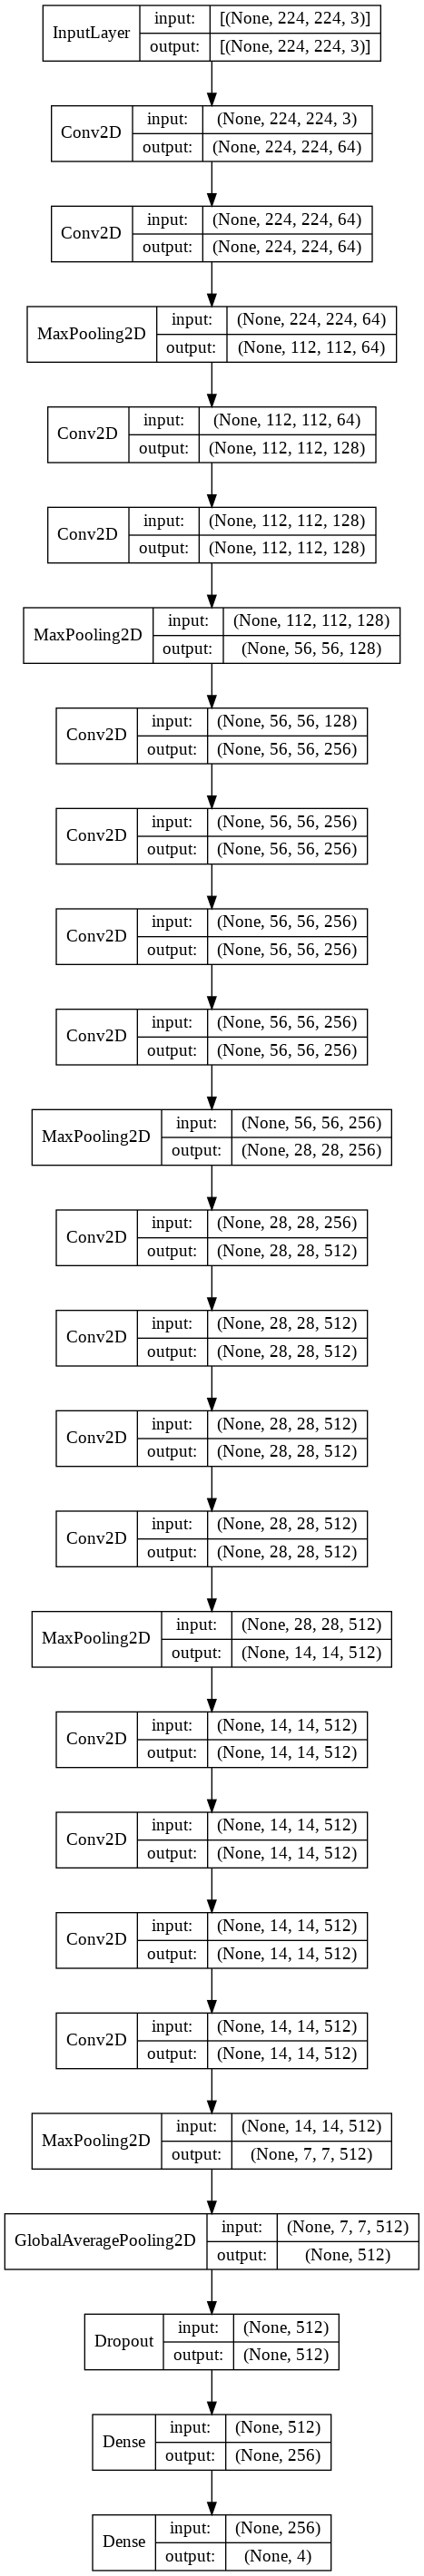

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model.compile(optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
              loss='categorical_crossentropy' ,
              metrics = ['accuracy']
              )

In [ ]:
hist=model.fit(train_generator,
          epochs=nb_epoch,
          validation_data=validation_generator
         ) 

Epoch 1/15
92/92 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.7062  